## Getting the polarity of the text
Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement, and is calculated by Polarity= (Pos-Neg)/(Pos+Neg). Whether a word is positive or negative is determined by the LoughranMcDonald_MasterDictionary

reference https://joecoelhosj.github.io/tutorial/newsarticlesentiment/

In [1]:
# Importing our required libraries
import os
import pandas as pd
from lxml import etree
from bs4 import BeautifulSoup
import random
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
import nltk
import spacy
import re

# scikit-learn library will generate our document-term matrix
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

# topic modelling
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
from pprint import pprint

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import random
random.seed(929)

In [2]:
# import the dataset
wsj = pd.read_csv('..//data/wsj_full.csv')
master = pd.read_csv('..//data/LoughranMcDonald_MasterDictionary_2016.csv') # LoughranMcDonald master word list

In [3]:
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words # list of stop words

# define the function to clean the test -remove stop words, punctuation
def clean_text(text):
    s = re.sub(r'[^\w\s]','', text) #remove punctuation
    word = s.split() # convert the text to a list of words
    word = [x.lower() for x in word] # convert to lower case
    word = [wo for wo in word if not wo in all_stopwords] # remove stop words
    return word

# convert the positive/negative words to a list
positive = master[master["Positive"]>0]
negative = master[master["Negative"]>0]

pos_words = positive["Word"].tolist()
neg_words = negative["Word"].tolist()

pos_words = [word.lower() for word in pos_words]
neg_words = [word.lower() for word in neg_words]

def word_count(text):
    content = clean_text(text)
    words_new_pos = [word for word in content if word in pos_words]
    words_new_neg = [word for word in content if word in neg_words]
    try: 
        polarity = (len(words_new_pos) - len(words_new_neg))/(len(words_new_pos) + len(words_new_neg)) # calculate polarity
    except ZeroDivisionError:
        polarity = 0
    return polarity

In [4]:
wsj['Polarity'] = wsj['Text'].apply(lambda x: word_count(x))
wsj.head(5)

,Article ID,Title,Text,Date,Company,Topics,Location,Person,Topic_Num,Topic_Perc_Contrib,Keywords,Polarity
0,2424324530.xml,Rate for 30-Year Mortgage Falls to Lowest on R...,"\nIn a year of financial firsts, this one stan...",2020-07-17,"['Fannie Mae', 'Freddie Mac', 'Fannie Mae', 'F...","['Purchasing', 'Home loans', 'Real estate sale...",[],[],14.0,0.6253,"economy, banks, market, rates, economic, inves...",-0.411765
1,2249646792.xml,New Jersey Averts Government Shutdown --- Gov....,\nNew Jersey Gov. Phil Murphy signed a $38.7 b...,2019-07-01,"['Senate', 'NJ Transit']","['Governors', 'Legislatures', 'Tax rates', 'Go...",['New Jersey'],"['Bramnick, Jon']",10.0,0.8559,"state, county, city, california, mayor, offici...",-0.538462
2,2325697446.xml,Trump's Impeachment Rebuke Bookended by Policy...,\nWASHINGTON -- Even for a presidency defined ...,2019-12-14,"['Brookings Institution', 'Congress', 'Islamic...","['Investigations', 'Presidents', 'Impeachment'...","['Mexico', 'Russia', 'United States--US', 'Can...","['Trump, Donald J', 'Parscale, Brad', 'Pelosi,...",11.0,0.8427,"trump, president, house, republican, democrat,...",-0.302326
3,2218797313.xml,Washington's Biggest Lobbyist Gets Shut Out --...,"\nA month before his inauguration, and shortly...",2019-05-03,"['Republican Party', 'US Chamber of Commerce']","['Nominations', 'Health care policy', 'Politic...",['United States--US'],"['Trump, Donald J', 'Coats, Dan']",11.0,0.4268,"trump, president, house, republican, democrat,...",-0.473684
4,2352540052.xml,Dollar's Surge Is Hurdle for Shares,\nInvestors worried about the impact of the co...,2020-02-10,"['PepsiCo Inc', 'Columbia Threadneedle Investm...","['Coronaviruses', 'Global economy', 'Interest ...","['United Kingdom--UK', 'New York', 'United Sta...","['Trump, Donald J']",0.0,0.4884,"company, market, investor, price, billion, sha...",-0.405405


In [5]:
tp_li = [0, 2, 6, 7, 8, 9, 10, 14, 17, 19]

senti_selected = wsj[wsj['Topic_Num'].isin(tp_li)] 
senti = pd.DataFrame(senti_selected.groupby(by = 'Date', as_index = False)['Polarity'].mean()) # daily mean polarity

In [6]:
senti['Polarity'].describe()

count    611.000000
mean      -0.422464
std        0.100271
min       -0.706179
25%       -0.494216
50%       -0.422854
75%       -0.356353
max       -0.072394
Name: Polarity, dtype: float64

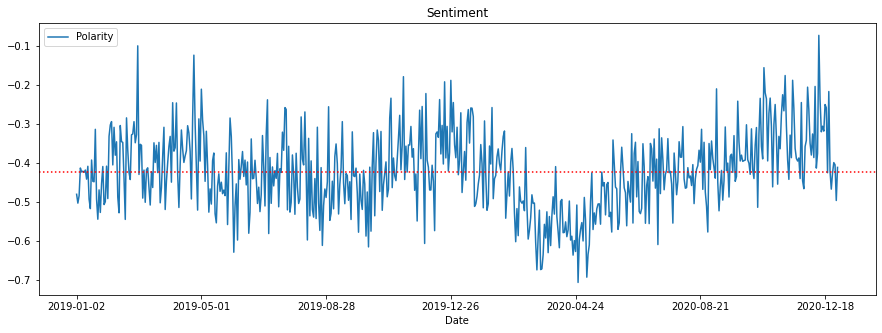

In [7]:
senti.plot(x = 'Date', figsize = (15, 5), title = 'Sentiment')
plt.axhline(-0.422, color = 'r', linestyle = ':')
plt.show()